In [82]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from functools import reduce
from statistics import mean
from rdkit import Chem

from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [83]:
bcf_mordred = pd.read_csv('data/bcf_mordred.csv', index_col=0)
bcf_ecfp4 = pd.read_csv('data/bcf_ecfp4_1024.csv', index_col=0)

# pass in dataframe
def preprocess(bcf_data, combined=False):
    
    # for merging Mordred and ECFP4 descriptors
    # bcf_data should be list with 2 elements
    if combined:
        bcf_data[1] = bcf_data[1].drop(columns=['CAS', 'logBCF', 'Dataset', 'cSMILES', 'is_pfas'], axis=1)
        bcf_data = bcf_data[0].join(bcf_data[1], how='inner')
    
    # keep out final pfas validation set
    bcf_pfas = bcf_data[bcf_data['is_pfas'] == True]
    bcf_nonpfas = bcf_data[bcf_data['is_pfas'] == False]

    # non-pfas used for training and testing set
    head1 = bcf_nonpfas[['CAS', 'Dataset', 'cSMILES', 'is_pfas']]
    data1 = bcf_nonpfas.drop(columns=['CAS', 'Dataset', 'cSMILES', 'is_pfas'], axis=1)
    
    # pfas for final validation
    head2 = bcf_pfas[['CAS', 'Dataset', 'cSMILES', 'is_pfas']]
    data2 = bcf_pfas.drop(columns=['CAS', 'Dataset', 'cSMILES', 'is_pfas'], axis=1)
    
    # filter out zero variance features using sklearn
    # make sure these also applied to pfas dataset
    sel = VarianceThreshold()
    sel.fit(data1)
    s = sel.get_support(indices=True)
    
    pre = data1[data1.columns[s]]
    pre_val = data2[data2.columns[s]]

    y = pre.pop('logBCF').to_numpy()
    X = pre.to_numpy()

    y_final = pre_val.pop('logBCF').to_numpy()
    X_final = pre_val.to_numpy()

    feature_names = np.array(list(pre))
    
    return X, y, X_final, y_final, feature_names

In [84]:
# Mordred
X_m, y_m, X_final_m, y_final_m, feature_names_m = preprocess(bcf_mordred)

# ECFP4
X_e, y_e, X_final_e, y_final_e, feature_names_e = preprocess(bcf_ecfp4)

# Combined
X_c, y_c, X_final_c, y_final_c, feature_names_c = preprocess([bcf_mordred, bcf_ecfp4], combined=True)

# print(X_m.shape)
# print(X_e.shape)
# print(X_c.shape)

In [73]:
# Cross fold validation random forest, followed by calculating permutation importance

def rf_sel(X, y, feature_names, splits=5, md=32):
    kf = KFold(n_splits=splits, shuffle=True, random_state=1)
    fold_features = []
    coef = []

    for fold_no, (train_index, test_index) in enumerate(kf.split(X)):
        print("Fold ", fold_no, " in process...")
        # Retrieve our training and testing set arrays, X = features, y = label
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # We will use RF regressor as our baseline for feature selection
        rfr = RandomForestRegressor(max_depth=md, random_state=0)
        rfr.fit(X_train, y_train)
        score = rfr.score(X_test, y_test)
        coef.append(score)
        print("Coefficient of determination on test data: {:.2f}".format(score))

        # Permutation feature importance step
        result = permutation_importance(rfr, X_train, y_train, n_repeats=10, random_state=1)

        # argsort() returns array of indices that map to values in given value array in order of smallest to largest
        feature_importance_id_x = result.importances_mean.argsort()
        fold_features.append(feature_importance_id_x)

        plt.boxplot(
            result.importances[feature_importance_id_x[-20:]].T,
            vert=False,
            labels=feature_names[feature_importance_id_x[-20:]],
        )
        plt.show()

    print("Mean coef: ", mean(coef))
    return fold_features

Fold  0  in process...
Coefficient of determination on test data: 0.67


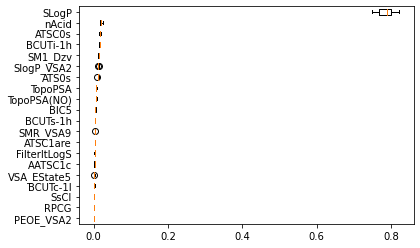

Fold  1  in process...
Coefficient of determination on test data: 0.77


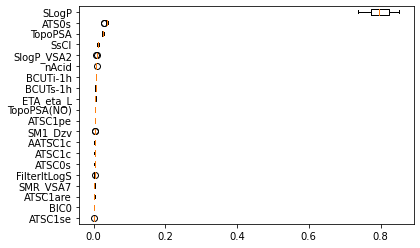

Fold  2  in process...
Coefficient of determination on test data: 0.74


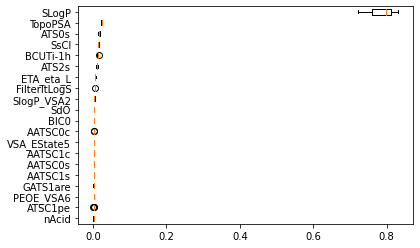

Fold  3  in process...
Coefficient of determination on test data: 0.76


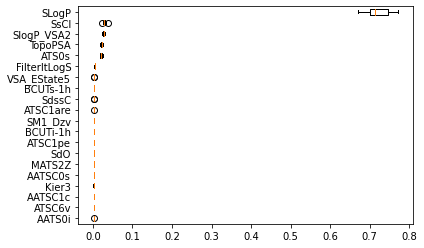

Fold  4  in process...
Coefficient of determination on test data: 0.72


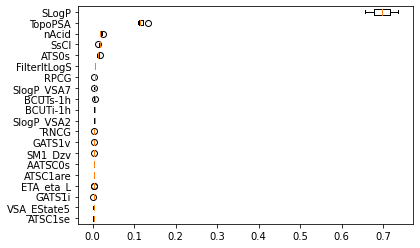

Mean coef:  0.7327112315826018


In [52]:
fold_features_m = rf_sel(X_m, y_m, feature_names_m)
%store fold_features_m

In [122]:
# Now look at feature intersection across all 5 folds
fold_features_top_500 = [fold_features_m[i][-500:] for i in range(5)]
fold_features_top_1000 = [fold_features_m[i][-1000:] for i in range(5)]
common_m_500 = reduce(np.intersect1d, fold_features_top_500)
common_m_1000 = reduce(np.intersect1d, fold_features_top_1000)

# print(feature_names_m[common_m])
print('Significant features common to all folds:', str(len(feature_names_m[common_m_500])) + '/500')
print('Significant features common to all folds:', str(len(feature_names_m[common_m_1000])) + '/1000')

Significant features common to all folds: 304/500
Significant features common to all folds: 874/1000


Fold  0  in process...
Coefficient of determination on test data: 0.66


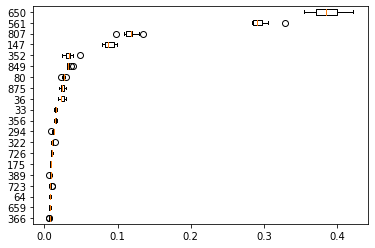

Fold  1  in process...
Coefficient of determination on test data: 0.60


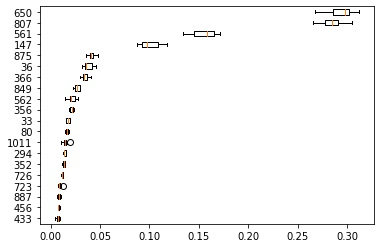

Fold  2  in process...
Coefficient of determination on test data: 0.50


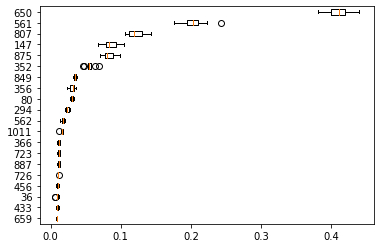

Fold  3  in process...
Coefficient of determination on test data: 0.59


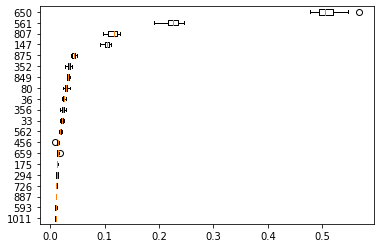

Fold  4  in process...
Coefficient of determination on test data: 0.54


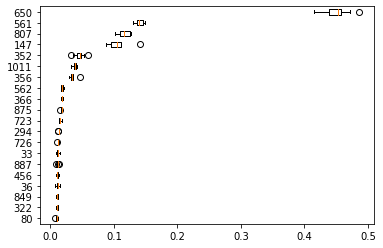

Mean coef:  0.5778236031031898


In [54]:
fold_features_e = rf_sel(X_e, y_e, feature_names_e)
%store fold_features_e

In [55]:
fold_features_top = [fold_features_e[i][-500:] for i in range(5)]
common_e = reduce(np.intersect1d, fold_features_top)
# print(feature_names_e[common_e])
print('Significant features common to all folds:', str(len(feature_names_e[common_e])) + '/500')

Significant features common to all folds: 300/500


Fold  0  in process...
Coefficient of determination on test data: 0.67


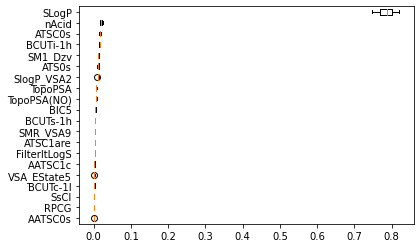

Fold  1  in process...
Coefficient of determination on test data: 0.77


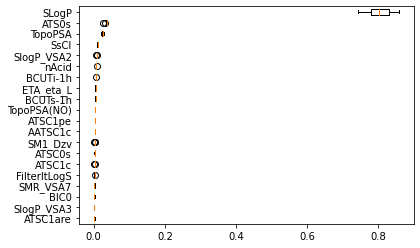

Fold  2  in process...
Coefficient of determination on test data: 0.74


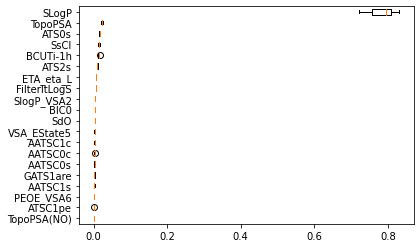

Fold  3  in process...
Coefficient of determination on test data: 0.77


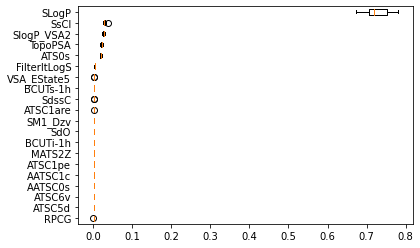

Fold  4  in process...
Coefficient of determination on test data: 0.72


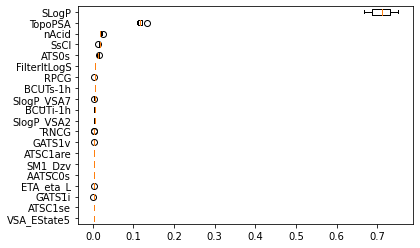

Mean coef:  0.7320226674166143


In [56]:
fold_features_c = rf_sel(X_c, y_c, feature_names_c)
%store fold_features_c

In [94]:
# basic MLPRegressor run on dataset, see results
# r^2, mae, rmse
# same splits as before as long as random_state is the same

# top cannot exceed number of features
def mlpr_sel(X, y, fold_features, splits=5, top=300, **kwargs):
    kf = KFold(n_splits=splits, shuffle=True, random_state=1)
    metrics = {'r2': [], 'mae': [], 'rmse': []}
    
    for fold_no, (train_index, test_index) in enumerate(kf.split(X)):
        print("Fold ", fold_no, " in process...")
        
        X_top = X[:, fold_features[fold_no][-abs(top):]]
        
        # retrieve our training and testing set arrays, X = features, y = label
        X_train, y_train = X_top[train_index], y[train_index]
        X_test, y_test = X_top[test_index], y[test_index]

        # need to scale data beforehand
        X_scaler = StandardScaler()
        X_scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        
        y_scaler = StandardScaler()
        y_scaler.fit(y_train.reshape(-1, 1))
        y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
        y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

        regr = MLPRegressor(random_state = fold_no, **kwargs)
        regr.fit(X_train_scaled, y_train_scaled.ravel())

        y_pred = regr.predict(X_test_scaled)
        
        metrics['r2'].append(r2_score(y_test_scaled, y_pred))
        metrics['mae'].append(mean_absolute_error(y_test_scaled, y_pred))
        metrics['rmse'].append(mean_squared_error(y_test_scaled, y_pred, squared=False))

    print("Mean r2: ", mean(metrics['r2']))
    print("Mean mae: ", mean(metrics['mae']))
    print("Mean rmse: ", mean(metrics['rmse']))
    return metrics

In [95]:
# Mordred DNN
dnn_m = mlpr_sel(X_m, y_m, fold_features_m, 
                 hidden_layer_sizes=(700, 700, 700, 700), 
                 max_iter=500, 
                 solver='adam', 
                 learning_rate='adaptive')
%store dnn_m

Fold  0  in process...
Fold  1  in process...
Fold  2  in process...
Fold  3  in process...
Fold  4  in process...
Mean r2:  0.7143151775201283
Mean mae:  0.38267947873165237
Mean rmse:  0.5316729118241931


In [97]:
# ECFP4 DNN
dnn_e = mlpr_sel(X_e, y_e, fold_features_e, 
                 hidden_layer_sizes=(600, 600, 600, 600, 600, 600), 
                 max_iter=1000,  
                 learning_rate_init=0.001)
%store dnn_e

Fold  0  in process...
Fold  1  in process...
Fold  2  in process...
Fold  3  in process...
Fold  4  in process...
Mean r2:  0.31967566451049595
Mean mae:  0.6500268685547471
Mean rmse:  0.8224364151060899


In [92]:
# Mordred and ECFP4 DNN (non-independent)
dnn_c = mlpr_sel(X_c, y_c, fold_features_c, 
                 hidden_layer_sizes=(700, 700, 700, 700), 
                 max_iter=500, 
                 solver='adam', 
                 learning_rate='adaptive')
%store dnn_c

Fold  0  in process...
Fold  1  in process...
Fold  2  in process...
Fold  3  in process...
Fold  4  in process...
Mean r2:  0.7075004840704893
Mean mae:  0.388086448978751
Mean rmse:  0.5380507793634806


In [114]:
# Retain top Mordred features, top ECFP features for independently selected then combined features
X_d = np.concatenate((X_c[:, common_m_500], X_c[:, common_e+X_m.shape[1]]), axis=1)
y_d = y_c
X_final_d = np.concatenate((X_final_c[:, common_m_500], X_final_c[:, common_e+X_m.shape[1]]), axis=1)
y_final_d = y_final_c
common_d = np.concatenate((common_m_500, common_e+X_m.shape[1]))
feature_names_d = feature_names_c[common_d]

In [106]:
# Mordred-ECFP4 Independent DNN
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled_d = X_scaler.fit_transform(X_d)
y_scaled_d = y_scaler.fit_transform(y_d.reshape(-1, 1))

scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
cv = KFold(n_splits=5, shuffle=True, random_state=2)

mlpr = MLPRegressor(random_state=3, hidden_layer_sizes=(700, 700, 700, 700, 700), 
                    max_iter=500)
scores_dnn = cross_validate(mlpr, X=X_scaled_d, y=y_scaled_d.ravel(), scoring=scoring, cv=cv)
%store scores_dnn

rfr = RandomForestRegressor(max_depth=32, random_state=0)
scores_rfr = cross_validate(rfr, X=X_d, y=y_d.ravel(), scoring=scoring, cv=cv)
%store scores_rfr

In [102]:
# Best RF model so far on general dataset: r2 = .737
print(scores_rfr.keys())
print('Independent Random Forest Mean: ', mean(scores_rfr['test_r2']))

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error'])
Independent Random Forest Mean:  0.7371915110860555


In [107]:
# Best NN model so far on general dataset: r2 = .714
print(scores_dnn.keys())
print('Independent DNN Mean: ', mean(scores_dnn['test_r2']))

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error', 'test_neg_root_mean_squared_error'])
Independent DNN Mean:  0.6535200119256803


In [124]:
# Export datasets for hyperparameter tuning in tensorflow:
# 1. Mordred only dataset top features
# 2. ECFP4 + Mordred independently combined total dataset
# 3. ECFP4 + Mordred independently selected top dataset
head = bcf_mordred[['CAS', 'logBCF', 'Dataset', 'cSMILES', 'is_pfas']]

# mordred only top features
X_m_1000 = X_m[:, common_m_1000]
X_final_m_1000 = X_final_m[:, common_m_1000]
feature_names_m_1000 = feature_names_m[common_m_1000]

agg_m = np.concatenate((X_m_1000, X_final_m_1000), axis=0)
agg_c = np.concatenate((X_c, X_final_c), axis=0)
agg_d = np.concatenate((X_d, X_final_d), axis=0)

#X_c + X_final_c, y_c + y_final_c
pd_agg_m = pd.DataFrame(agg_m, columns = feature_names_m_1000)
pd_agg_c = pd.DataFrame(agg_c, columns = feature_names_c)
pd_agg_d = pd.DataFrame(agg_d, columns = feature_names_d)

# Concatenate then with heads
bcf_mordred_top = pd.concat((head, pd_agg_m), axis=1)
bcf_mordred_ecfp4_total = pd.concat((head, pd_agg_c), axis=1)
bcf_mordred_ecfp4_top = pd.concat((head, pd_agg_d), axis=1)

# Export to CSV for tensorflow
bcf_mordred_top.to_csv('data/hyptuning/bcf_mordred_top.csv')
bcf_mordred_ecfp4_total.to_csv('data/hyptuning/bcf_mordred_ecfp4_total.csv')
bcf_mordred_ecfp4_top.to_csv('data/hyptuning/bcf_mordred_ecfp4_top.csv')